In [1]:
import pandas as pd
import requests
import time
import dask
import intake
import dask.dataframe as dd

# Querying the Metadatabase

In [2]:
HOST = 'localhost'
PORT = 80
ENDPOINT_URI = f'http://{HOST}:{PORT}'

## Advanced Queries with GraphQL

With GraphQL you can query exactly what you want, rather than having to recieve the whole table from the database This is useful in cases where the whole table has many columns, but you are interested in just a subset of them.

The GraphQL endpoint is located at `/graphql` and recieves HTTP POST requests with the `query` parameter.

In [3]:
# Write our GraphQL query.
query = """
query {
    get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}) {
        signal_datasets {
            name
            dimensions
        }
    }
}
"""
# Query the API and get a JSON response
response = requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})
response.json()

{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_EFPS CURRENT',
     'dimensions': ['time']},
    {'name': 'AMC_ERROR FIELD/02', 'dimensions': ['time']},
    {'name': 'AMC_ERROR FIELD/05', 'dimensions': ['time']}]}}}

In [4]:
# Write our GraphQL query.
query = """
query {
    get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}) {
        signal_datasets {
            name
            dimensions
            get_shots (where: {shot_id: {lt: 11700}}){
                shots {
                    shot_id
                }
            }
        }
    }
}
"""
# Query the API and get a JSON response
response = requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})
response.json()

{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_EFPS CURRENT',
     'dimensions': ['time'],
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}},
    {'name': 'AMC_ERROR FIELD/02',
     'dimensions': ['time'],
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}},
    {'name': 'AMC_ERROR FIELD/05',
     'dimensions': ['time'],
     'get_shots': {'shots': [{'shot_id': 11695},
       {'shot_id': 11696},
       {'shot_id': 11697},
       {'shot_id': 11698},
       {'shot_id': 11699}]}}]}}}

GraphQL queries are paginated. You may access other entries by including the page metadata:

In [5]:
from string import Template

def do_query(cursor: str = None):
    query = """
    query {
        get_signal_datasets (limit: 3, where: {name: {contains: "AMC"}}, ${cursor}) {
            signal_datasets {
                name
                dimensions
                get_shots (where: {shot_id: {lt: 11700}}){
                    shots {
                        shot_id
                    }
                }
            }
            page_meta {
              next_cursor
              total_items
              total_pages
            }
        }
    }
    """
    template = Template(query)
    query = template.substitute(cursor=f'cursor: "{cursor}"' if cursor is not None else "")
    return requests.post(f'{ENDPOINT_URI}/graphql', json={'query': query})


def iterate_responses():
    cursor = None
    while True:
        response = do_query(cursor)
        payload = response.json() 
        yield payload
        cursor = payload['data']['get_signal_datasets']['page_meta']['next_cursor']
        if cursor is None:
            return

responses = iterate_responses()
print(next(responses))
print(next(responses))
print(next(responses))

{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_EFPS CURRENT', 'dimensions': ['time'], 'get_shots': {'shots': [{'shot_id': 11695}, {'shot_id': 11696}, {'shot_id': 11697}, {'shot_id': 11698}, {'shot_id': 11699}]}}, {'name': 'AMC_ERROR FIELD/02', 'dimensions': ['time'], 'get_shots': {'shots': [{'shot_id': 11695}, {'shot_id': 11696}, {'shot_id': 11697}, {'shot_id': 11698}, {'shot_id': 11699}]}}, {'name': 'AMC_ERROR FIELD/05', 'dimensions': ['time'], 'get_shots': {'shots': [{'shot_id': 11695}, {'shot_id': 11696}, {'shot_id': 11697}, {'shot_id': 11698}, {'shot_id': 11699}]}}], 'page_meta': {'next_cursor': 'NTMw', 'total_items': 46, 'total_pages': 16}}}}
{'data': {'get_signal_datasets': {'signal_datasets': [{'name': 'AMC_P2IL COIL CURRENT', 'dimensions': ['time'], 'get_shots': {'shots': [{'shot_id': 11695}, {'shot_id': 11696}, {'shot_id': 11697}, {'shot_id': 11698}, {'shot_id': 11699}]}}, {'name': 'AMC_P2IL FEED CURRENT', 'dimensions': ['time'], 'get_shots': {'shots': [{'

## Querying with the REST API

In [6]:
response = requests.get(f'{ENDPOINT_URI}/json/signal_datasets?size=2')
response.json()

{'items': [{'@context': 'https://schema.org/',
   '@type': 'Dataset',
   'signal_dataset_id': 1151,
   'name': 'ESX_UPPER INV RADIUS',
   'units': 'cm',
   'rank': 1,
   'uri': '/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/archive/mast/ESX_UPPER_INV_RADIUS.nc',
   'description': '',
   'signal_type': 'Analysed',
   'quality': 'Not Checked',
   'doi': '',
   'dimensions': ['time']},
  {'@context': 'https://schema.org/',
   '@type': 'Dataset',
   'signal_dataset_id': 1150,
   'name': 'ESX_UPPER INV PSI',
   'units': 'Wb/rad',
   'rank': 1,
   'uri': '/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/archive/mast/ESX_UPPER_INV_PSI.nc',
   'description': '',
   'signal_type': 'Analysed',
   'quality': 'Not Checked',
   'doi': '',
   'dimensions': ['time']}],
 'total': 1151,
 'page': 1,
 'size': 2,
 'pages': 576,
 'column_metadata': {'context_': 'str',
  'type_': 'str',
  'signal_dataset_id': 'int',
  'name': 'str',
  'units': 'str',
  'rank': 'int',
  'uri': 'str',
  'description': 'str',
  '

JSON API responses are paginated. You can use the option `page=xx` to access the next few items.

In [7]:
response = requests.get(f'{ENDPOINT_URI}/json/signal_datasets?size=2&page=2')
response.json()

{'items': [{'@context': 'https://schema.org/',
   '@type': 'Dataset',
   'signal_dataset_id': 1149,
   'name': 'ESX_STATUS',
   'units': 'Status',
   'rank': 1,
   'uri': '/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/archive/mast/ESX_STATUS.nc',
   'description': '',
   'signal_type': 'Analysed',
   'quality': 'Not Checked',
   'doi': '',
   'dimensions': ['time']},
  {'@context': 'https://schema.org/',
   '@type': 'Dataset',
   'signal_dataset_id': 1148,
   'name': 'ESX_PASSNUMBER',
   'units': 'Passno',
   'rank': 1,
   'uri': '/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/archive/mast/ESX_PASSNUMBER.nc',
   'description': '',
   'signal_type': 'Analysed',
   'quality': 'Not Checked',
   'doi': '',
   'dimensions': ['time']}],
 'total': 1151,
 'page': 2,
 'size': 2,
 'pages': 576,
 'column_metadata': {'context_': 'str',
  'type_': 'str',
  'signal_dataset_id': 'int',
  'name': 'str',
  'units': 'str',
  'rank': 'int',
  'uri': 'str',
  'description': 'str',
  'signal_type': 'object'

### Loading Paginated Responses with Dask

In [8]:
response = requests.get(f'{ENDPOINT_URI}/json/shots')
num_pages = response.json()['pages']

@dask.delayed
def load_one_query(i): 
    response = requests.get(f'{ENDPOINT_URI}/json/shots?page={i}')
    response = response.json()
    return pd.DataFrame.from_dict(response['items']).astype(response['column_metadata'])

df = dd.from_delayed([load_one_query(i) for i in range(1, 5)])
df

,shot_id,timestamp,preshot_description,postshot_description,campaign,reference_shot,scenario,heating,pellets,rmp_coil,current_range,divertor_config,plasma_shape,comissioner,facility,cpf_p03249,cpf_p04673,cpf_p04674,cpf_p04675,cpf_p04676,cpf_p04677,cpf_p04678,cpf_p04679,cpf_p04680,cpf_p04681,cpf_p04833,cpf_p04993,cpf_p05007,cpf_p05008,cpf_p05009,cpf_p05010,cpf_p05011,cpf_p05015,cpf_p05016,cpf_p05017,cpf_p05025,cpf_p05027,cpf_p05028,cpf_p05029,cpf_p05030,cpf_p05032,cpf_p05033,cpf_p05153,cpf_p06000,cpf_p06001,cpf_p06002,cpf_p06003,cpf_p06004,cpf_p10963,cpf_p10964,cpf_p12441,cpf_p12450,cpf_p12451,cpf_p12452,cpf_p15202,cpf_p15203,cpf_p15209,cpf_p15659,cpf_p15660,cpf_p15661,cpf_p20000,cpf_p20204,cpf_p20205,cpf_p20206,cpf_p20207,cpf_p20208,cpf_p21010,cpf_p21011,cpf_p21012,cpf_p21021,cpf_p21022,cpf_p21029,cpf_p21035,cpf_p21037,cpf_p21041,cpf_p21042,cpf_p21043,cpf_p21044,cpf_p21045,cpf_p21046,cpf_p21047,cpf_p21048,cpf_p21051,cpf_p21052,cpf_p21053,cpf_p21054,cpf_p21055,cpf_p21056,cpf_p21075,cpf_p21076,cpf_p21077,cpf_p21078,cpf_p21079,cpf_p21080,cpf_p21081,cpf_p21082,cpf_p21083,cpf_p21084,cpf_p21085,cpf_p21086,cpf_p21087,cpf_p21088,cpf_p21089,cpf_p21092,cpf_p21093,cpf_abort,cpf_amin_ipmax,cpf_amin_max,cpf_amin_truby,cpf_area_ipmax,cpf_area_max,cpf_area_truby,cpf_bepmhd_ipmax,cpf_bepmhd_max,cpf_bepmhd_truby,cpf_betmhd_ipmax,cpf_betmhd_max,cpf_betmhd_truby,cpf_bt_ipmax,cpf_bt_max,cpf_bt_truby,cpf_c2ratio,cpf_column_temp_in,cpf_column_temp_out,cpf_creation,cpf_dwmhd_ipmax,cpf_dwmhd_max,cpf_dwmhd_truby,cpf_enbi_max_ss,cpf_enbi_max_sw,cpf_exp_date,cpf_exp_number,cpf_exp_time,cpf_gdc_duration,cpf_gdc_time,cpf_ibgas_pressure,cpf_ip_av,cpf_ip_max,cpf_jnbi_ipmax,cpf_jnbi_ipmax_ss,cpf_jnbi_ipmax_sw,cpf_jnbi_max,cpf_jnbi_max_ss,cpf_jnbi_max_sw,cpf_jnbi_total,cpf_jnbi_total_ss,cpf_jnbi_total_sw,cpf_jnbi_truby,cpf_jnbi_truby_ss,cpf_jnbi_truby_sw,cpf_johm_ipmax,cpf_johm_max,cpf_johm_total,cpf_johm_truby,cpf_kappa_ipmax,cpf_kappa_max,cpf_kappa_truby,cpf_li_2_ipmax,cpf_li_2_max,cpf_li_2_truby,cpf_li_3_ipmax,cpf_li_3_max,cpf_li_3_truby,cpf_log_base_pressure,cpf_ndl_co2_ipmax,cpf_ndl_co2_max,cpf_ndl_co2_truby,cpf_ne0_ipmax,cpf_ne0_max,cpf_ne0_truby,cpf_ne0ratio_ipmax,cpf_ne0ruby,cpf_ne_bar_ipmax,cpf_ne_yag_bar_ipmax,cpf_ngreenwald_ipmax,cpf_ngreenwaldratio_ipmax,cpf_o2ratio,cpf_objective,cpf_pe0_ipmax,cpf_pe0_max,cpf_pe0_truby,cpf_pe0ruby,cpf_pic,cpf_pnbi_ipmax,cpf_pnbi_ipmax_ss,cpf_pnbi_ipmax_sw,cpf_pnbi_max,cpf_pnbi_max_ss,cpf_pnbi_max_sw,cpf_pnbi_truby,cpf_pnbi_truby_ss,cpf_pnbi_truby_sw,cpf_pohm_ipmax,cpf_pohm_max,cpf_pohm_truby,cpf_postshot,cpf_prad_ipmax,cpf_prad_max,cpf_prad_truby,cpf_pradne2,cpf_preshot,cpf_program,cpf_pulno,cpf_q95_ipmax,cpf_q95_min,cpf_q95_truby,cpf_reference,cpf_rgeo_ipmax,cpf_rgeo_max,cpf_rgeo_truby,cpf_rinner_da,cpf_rinner_efit,cpf_rmag_efit,cpf_router_da,cpf_router_efit,cpf_sarea_ipmax,cpf_sarea_max,cpf_sarea_truby,cpf_sl,cpf_summary,cpf_tamin_max,cpf_tarea_max,cpf_tautot_ipmax,cpf_tautot_max,cpf_tautot_truby,cpf_tbepmhd_max,cpf_tbetmhd_max,cpf_tbt_max,cpf_tdwmhd_max,cpf_te0_ipmax,cpf_te0_max,cpf_te0_truby,cpf_te0ratio_ipmax,cpf_te0ruby,cpf_te_yag_bar_ipmax,cpf_tend,cpf_tend_ibgas,cpf_tend_nbi,cpf_tend_nbi_ss,cpf_tend_nbi_sw,cpf_term_code,cpf_tftend,cpf_tftstart,cpf_tipmax,cpf_tkappa_max,cpf_tli_2_max,cpf_tli_3_max,cpf_tndl_co2_max,cpf_tne0_max,cpf_tpe0_max,cpf_tpnbi_max,cpf_tpnbi_max_ss,cpf_tpnbi_max_sw,cpf_tpohm_max,cpf_tprad_max,cpf_tq95_min,cpf_trgeo_max,cpf_truby,cpf_tsarea_max,cpf_tstart,cpf_tstart_ibgas,cpf_tstart_nbi,cpf_tstart_nbi_ss,cpf_tstart_nbi_sw,cpf_ttautot_max,cpf_tte0_max,cpf_tvol_max,cpf_twmhd_max,cpf_tzeff_max,cpf_useful,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [9]:
df.compute()

,shot_id,timestamp,preshot_description,postshot_description,campaign,reference_shot,scenario,heating,pellets,rmp_coil,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,47206,2023-03-31T16:04:44,retry,"rtp stops st07 and st25, plus event 40 and 50 ...",MU3,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,47205,2023-03-31T15:52:21,"Brake chopper test. Restore 44539. P1, TF and ...",abort,MU3,44539.0,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,47204,2023-03-31T15:38:20,Repeat daily test shot with PS enable windows ...,Error in channels 11 and 12 on bolometer. Wave...,MU3,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,47203,2023-03-31T15:19:43,Restore prepared setup all-coil-first-shot. Ex...,"Looks OK, I don't have a code to test the magn...",MU3,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,47202,2023-03-31T14:59:33,retry,"Ran OK, no trips, all PF currents as demanded.",MU3,45847.0,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,47011,2023-01-21T09:54:47,[Integrated control test] Restore IntegratedCt...,Terminated early but the gas response was bett...,MU2,46994.0,15.0,Ohmic,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
46,47010,2023-01-21T09:31:38,[TF test] Restore All_Coil_First_Shot.,Currents look good.,MU2,<NA>,<NA>,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
47,47009,2023-01-20T17:57:31,"[FPP-02 TAEs] Repeat, diagnostics in position 1.",Good SW but only 30ms of south. Not useful for...,MU2,47008.0,14.0,<NA>,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
48,47008,2023-01-20T17:38:16,[FPP-02 TAEs] Straight repeat again. Diagnosti...,Density higher than the previous shot early on...,MU2,47007.0,14.0,2 Beams,False,False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Querying with File Streaming API

### Using Intake

Column(width_policy='max')
    [0] Row(width_policy='max')
        [0] PNG(str)
        [1] Column(width_policy='max')
            [0] Column(name='Select Catalog')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options={'meta_catalog': <...}, size=9, value=[<Intake catalog: m...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='＋', width=50)
                [1] Button(name='―', width=50)
                [2] Toggle(name='🔍', width=50)
        [2] Column(width_policy='max')
            [0] Column(name='Select Data Source')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options=OrderedDict([('shots', ...]), size=9, value=[name: shots
container: d...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='📊', width=50)
                [1] Toggle(disabled=True, name='⚙', width=50)
        [3] Column(height=240, name='Description', scroll=True, sizing_mode='stretch_width', width_policy='max')
            [0] Markdown(str)
    [1] Row(width_policy='max')
        [0] Row(height_policy='min', max_width=5000, name='Search', width_policy='max')
        [1] Column(max_width=5000, name='Add Catalog', width_policy='max')
        [2] Column(name='Plot', width_policy='max')
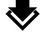

In [10]:
catalog = intake.open_catalog(f'{ENDPOINT_URI}/meta_catalog.yml')
gui = intake.interface.gui.GUI([catalog])
gui

Reading from the Intake catalog

In [11]:
catalog.signal_datasets.read()

,context_,type_,name,description,signal_type,quality,doi,dimensions,signal_dataset_id,units,rank,uri
0,https://schema.org/,Dataset,ABM_CALIB_SHOT,Shot used for calibration (obsolete),Analysed,Not Checked,,[time],1,,1,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
1,https://schema.org/,Dataset,ABM_CHANNEL_STATUS,"Failed = 0, OK = 1",Analysed,Not Checked,,"[time, dim_0]",2,,2,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
2,https://schema.org/,Dataset,ABM_CHANNEL_TYPE,"Channel type (0 = poloidal, 1 = co-tangential,...",Analysed,Not Checked,,"[time, dim_0]",3,,2,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
3,https://schema.org/,Dataset,ABM_GAIN,Gain of pre-amplifiers,Analysed,Not Checked,,"[time, dim_0]",4,,2,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
4,https://schema.org/,Dataset,ABM_I-BOL,Incident powers (x - channel),Analysed,Not Checked,,"[chord_number, time]",5,W/m^2,2,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
...,...,...,...,...,...,...,...,...,...,...,...,...
1146,https://schema.org/,Dataset,ESX_LOWER INV RADIUS,,Analysed,Not Checked,,[time],1147,cm,1,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
1147,https://schema.org/,Dataset,ESX_PASSNUMBER,,Analysed,Not Checked,,[time],1148,Passno,1,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
1148,https://schema.org/,Dataset,ESX_STATUS,,Analysed,Not Checked,,[time],1149,Status,1,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...
1149,https://schema.org/,Dataset,ESX_UPPER INV PSI,,Analysed,Not Checked,,[time],1150,Wb/rad,1,/home/ir-jack5/rds/rds-ukaea-mast-sPGbyCAPsJI/...


Direct access with the a known URI.

In [12]:
pd.read_parquet(f'{ENDPOINT_URI}/files/shots')

,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,comissioner,facility,cpf_objective,cpf_pic,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,retry,"rtp stops st07 and st25, plus event 40 and 50 ...",MU3,None,None,None,UKAEA,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
1,"Brake chopper test. Restore 44539. P1, TF and ...",abort,MU3,None,None,None,UKAEA,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
2,Repeat daily test shot with PS enable windows ...,Error in channels 11 and 12 on bolometer. Wave...,MU3,None,None,None,UKAEA,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
3,Restore prepared setup all-coil-first-shot. Ex...,"Looks OK, I don't have a code to test the magn...",MU3,None,None,None,UKAEA,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
4,retry,"Ran OK, no trips, all PF currents as demanded.",MU3,None,None,None,UKAEA,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25551,\nRAISE TO .58T\n,\nOK\n,M5,None,Conventional,None,None,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
25552,\nRAISE TO .56T\n,\nSTILL ALARMS BUT LOWER AGAIN\n,M5,None,Conventional,None,None,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
25553,\nRAISE TO 0.5T\n,"\nOK, ALARMS ARE LOWER\n",M5,None,Conventional,None,None,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN
25554,\nSTANDARD 0.3T TF SHOT\n,\nOK\n,M5,None,Conventional,None,None,MAST,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,NaN


Or even read the file in CSV format

In [13]:
pd.read_csv(f'{ENDPOINT_URI}/files/shots?format=csv')

/tmp/ipykernel_1747382/1734790811.py:1: DtypeWarning: Columns (4,5,6,7,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f'{ENDPOINT_URI}/files/shots?format=csv')


,Unnamed: 0,preshot_description,postshot_description,campaign,current_range,divertor_config,plasma_shape,comissioner,facility,cpf_objective,...,cpf_vol_ipmax,cpf_vol_max,cpf_vol_truby,cpf_wmhd_ipmax,cpf_wmhd_max,cpf_wmhd_truby,cpf_zeff_ipmax,cpf_zeff_max,cpf_zeff_truby,cpf_zmag_efit
0,0,retry,"rtp stops st07 and st25, plus event 40 and 50 ...",MU3,NaN,NaN,NaN,UKAEA,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"Brake chopper test. Restore 44539. P1, TF and ...",abort,MU3,NaN,NaN,NaN,UKAEA,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Repeat daily test shot with PS enable windows ...,Error in channels 11 and 12 on bolometer. Wave...,MU3,NaN,NaN,NaN,UKAEA,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Restore prepared setup all-coil-first-shot. Ex...,"Looks OK, I don't have a code to test the magn...",MU3,NaN,NaN,NaN,UKAEA,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,retry,"Ran OK, no trips, all PF currents as demanded.",MU3,NaN,NaN,NaN,UKAEA,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25551,25551,\nRAISE TO .58T\n,\nOK\n,M5,NaN,Conventional,NaN,NaN,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25552,25552,\nRAISE TO .56T\n,\nSTILL ALARMS BUT LOWER AGAIN\n,M5,NaN,Conventional,NaN,NaN,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25553,25553,\nRAISE TO 0.5T\n,"\nOK, ALARMS ARE LOWER\n",M5,NaN,Conventional,NaN,NaN,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25554,25554,\nSTANDARD 0.3T TF SHOT\n,\nOK\n,M5,NaN,Conventional,NaN,NaN,MAST,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Opening Remote Data Files

In [14]:
%%time
import zarr

handle = zarr.open_consolidated(f'{ENDPOINT_URI}/data/amc_test.zarr', mode='r')
# list(handle.groups())
keys = list(handle.groups())
keys = [k[0] for k in keys]
results ={}
for key in keys:
    g = handle[key]
    results[key] = dict(data=g["data"][:], error=g["error"][:], time=g["time"][:])

print(len(results))

1580
CPU times: user 4.23 s, sys: 873 ms, total: 5.1 s
Wall time: 9.4 s
